In [1]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 20})

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import gsw
from datetime import datetime,date
import os as os
from matplotlib.gridspec import GridSpec
from numpy.fft import fft,fft2,fftfreq
from scipy.interpolate import interp2d
from sklearn.linear_model import LinearRegression
from scipy import fftpack
from tqdm import tqdm
from scipy.stats import linregress,norm
import dask as da
import xarray as xar
import glob as glob
from cartopy.crs import PlateCarree 
from cartopy.feature import COASTLINE as COASTLINE



# OPEN DATASETS AND COMPUTE THE DENSITY

In [11]:

#Learning period (ISAS20)
RCR=xar.open_mfdataset('ISAS_TropicalPacific.nc').isel(depth=[0,1,2,3,4,5,6,7])
Clim1=RCR['TEMP_polyfit_coefficients'].sel(degree=0)+RCR['time']*RCR['TEMP_polyfit_coefficients'].sel(degree=1)
Clim2=np.zeros_like(Clim1) 
RCR['TEMP_polyfit_coefficients'].values = RCR['TEMP_polyfit_coefficients'].values*0
Clim1=RCR['PSAL_polyfit_coefficients'].sel(degree=0)+RCR['time']*RCR['PSAL_polyfit_coefficients'].sel(degree=1)
Clim2=np.zeros_like(Clim1)
RCR['PSAL_polyfit_coefficients'].values = RCR['PSAL_polyfit_coefficients'].values*0

timemin=1930
timemax=2001
Ny=RCR['latitude'].size
Nx=RCR['longitude'].size
Nz= RCR['depth'].size
NxNy=Ny*Nx
Btime=([np.datetime64(str(yr)+'-'+str(mth).zfill(2)) for yr in range(timemin,timemax+1) for mth in range(1,13) ])
Jtime=xar.DataArray(np.asanyarray((Btime-np.datetime64('1975-01')).astype('timedelta64[M]').astype('float64')),dims=['time'],coords={'time2':(['time'],Btime)})


p = gsw.conversions.p_from_z(-RCR['depth'], RCR['latitude'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
SA = gsw.conversions.SA_from_SP(RCR['PSAL'], p, RCR['longitude'], RCR['latitude'])
CT = gsw.conversions.CT_from_pt(SA, RCR['TEMP'])
Rho_RCR =  gsw.density.rho(SA, CT, p)
rho0 =  gsw.density.rho(SA, CT, p).isel(depth=0).mean()
Rho0 =  gsw.density.rho(SA, CT, p).groupby('time2.month').mean()-rho0

AlphabetR=xar.open_dataset('ISAS_AlphaBetaCoeffs.nc').rename({"ALPH":"alpha","BETA":"beta"}).isel(depth=[0,1,2,3,4,5,6,7])


#RedAnDA TS
RealAnDA_TS7 = xar.load_dataset('redAnDA_T&S_15modes.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy')
RealRho_TS7 = rho0.values+rho0.values[np.newaxis]*(RealAnDA_TS7.coeff.dot(RealAnDA_TS7.functions).sum('var'))
RealRho_TS7 = RealRho_TS7.groupby('JULD.month')+Rho0.rename({"latitude":"Lat","longitude":"Lon"})
RealAnDA_TS7=RealAnDA_TS7.assign({'functions':RealAnDA_TS7.functions/xar.concat((-AlphabetR.alpha.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'),(AlphabetR.beta.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'))),'var').values[:,:,np.newaxis]})
RealAnDA_TS7=RealAnDA_TS7.assign({'truncerr':RealAnDA_TS7.truncerr/xar.concat((-AlphabetR.alpha.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'),(AlphabetR.beta.mean('time').rename({"latitude":"Lat","longitude":"Lon"}).expand_dims('var'))),'var').values})
Temp_TS7 = RealAnDA_TS7['coeff'].dot(RealAnDA_TS7['functions']).isel(var=0)
Psal_TS7 = RealAnDA_TS7['coeff'].dot(RealAnDA_TS7['functions']).isel(var=1)
AbsTemp_TS7 = RealAnDA_TS7['coeff'].dot(RealAnDA_TS7['functions']).isel(var=0).groupby('JULD.month')+(+RCR['T_Climato'].rename({"latitude":"Lat","longitude":"Lon"}))
AbsPsal_TS7 = RealAnDA_TS7['coeff'].dot(RealAnDA_TS7['functions']).isel(var=1).groupby('JULD.month')+(+RCR['S_Climato'].rename({"latitude":"Lat","longitude":"Lon"}))


#EN4

EN4R = xar.open_dataset('EN4_FULL_Pac.nc').merge(xar.open_dataset('EN4_Salinity_FULL_Pac.nc'))
EN4R = EN4R.isel(depth=[0,1,2,3,4,5,6,7]).interp({"lat":RCR['latitude'],"lon":RCR['longitude']})
EN4R=EN4R.assign({'Temp':(EN4R.Temp.groupby('time2.month')+EN4R.Climato)})
EN4R=EN4R.assign({'Climato':(EN4R.Temp.where(EN4R['time2'].astype('datetime64[M]').isin(RCR['time2'].values.astype('datetime64[M]')),drop=True)).groupby('time2.month').mean()})
EN4R=EN4R.assign({'Temp':(EN4R.Temp.groupby('time2.month')-EN4R.Climato)})
EN4R=EN4R.assign({'Psal':(EN4R.Psal.groupby('time2.month')+EN4R.SClimato)})
EN4R=EN4R.assign({'SClimato':(EN4R.Psal.where(EN4R['time2'].astype('datetime64[M]').isin(RCR['time2'].values.astype('datetime64[M]')),drop=True)).groupby('time2.month').mean()})
EN4R=EN4R.assign({'Psal':(EN4R.Psal.groupby('time2.month')-EN4R.SClimato)})
Rho_EN4R5 = rho0.values+rho0.values[np.newaxis]*(AlphabetR['alpha'].mean('time').values*-(EN4R['Temp'])+AlphabetR['beta'].mean('time').values*(EN4R['Psal']))
Rho_EN4R5 = Rho_EN4R5.groupby('time2.month')+Rho0


#IAP

IAPR = xar.open_dataset('IAP_Temperature_1degree_Pac.nc').rename({"Psal":"Temp"}).sel({"depth_std":[5,10,50,100,200,300,400,500]}).isel({'time':slice(0,-12)}).merge(xar.open_dataset('IAP_Salinity_1degree_Pac.nc').sel({"depth_std":[5,10,50,100,200,300,400,500]}))
IAPR = IAPR.rename({'depth_std':'depth','lat':'latitude','lon':'longitude'}).interp({"latitude":RCR['latitude'],"longitude":RCR['longitude']})
IAPR=IAPR.assign({"time":(['time'],IAPR.time.values+np.timedelta64(14,'D'))})
IAPR=IAPR.assign({'Temp':(IAPR.Temp.groupby('time2.month')+IAPR.Climato)})
IAPR=IAPR.assign({'Climato':(IAPR.Temp.where(IAPR['time'].isin(RCR['time2'].values),drop=True).groupby('time2.month').mean())})
IAPR=IAPR.assign({'Temp':(IAPR.Temp.groupby('time2.month')-IAPR.Climato)})
IAPR=IAPR.assign({'Psal':(IAPR.Psal.groupby('time2.month')+IAPR.SClimato)})
IAPR=IAPR.assign({'SClimato':(IAPR.Psal.where(IAPR['time'].isin(RCR['time2'].values),drop=True).groupby('time2.month').mean())})
IAPR=IAPR.assign({'Psal':(IAPR.Psal.groupby('time2.month')-IAPR.SClimato)})

Rho_IAPR5 = rho0.values+rho0.values[np.newaxis]*(AlphabetR['alpha'].mean('time').values*-(IAPR['Temp'].transpose('time','depth','latitude','longitude'))+AlphabetR['beta'].mean('time').values*(IAPR['Psal'].transpose('time','depth','latitude','longitude')))
Rho_IAPR5 = Rho_IAPR5.groupby('time2.month')+Rho0


#UnivarS and UnivarT

redAnDA = xar.open_dataset('UnivarT_14modes.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy')

redAnDA_S = xar.open_dataset('UnivarS_14modes.nc').set_index({'NxNy':['Lat','Lon']}).unstack('NxNy')


Temp_Univar = redAnDA['coeff'].dot(redAnDA['functions'])
AbsTemp_Univar = redAnDA['coeff'].dot(redAnDA['functions']).groupby('JULD.month')+(+RCR['T_Climato'].rename({"latitude":"Lat","longitude":"Lon"}))
Psal_Univar = redAnDA_S['coeff'].dot(redAnDA_S['functions'])
AbsPsal_Univar = redAnDA_S['coeff'].dot(redAnDA_S['functions']).groupby('JULD.month')+(+RCR['S_Climato'].rename({"latitude":"Lat","longitude":"Lon"}))


Rho_Univar = rho0.values+rho0.values[np.newaxis]*(AlphabetR['alpha'].mean('time').values*-(Temp_Univar)+AlphabetR['beta'].mean('time').values*(Psal_Univar))
Rho_Univar = Rho_Univar.groupby('JULD.month')+Rho0


#OBSERVATIONS

ENPSAL2 = xar.load_dataset(glob.glob('ENsal_NoInterp*0NoFMoorAdjusted.nc')[0]).isel(depth=[0,1,2,3,4,5,6,7])
if 'POTM' in (list(xar.load_dataset(glob.glob('ENsal_NoInterp*0NoFMoorAdjusted.nc')[0]).isel(depth=[0,1,2,3,4,5,6,7]).keys())):
    ENPSAL2=ENPSAL2.rename({'POTM':'PSAL'})
for i in range(0,7):
    if 'POTM' in (list(xar.load_dataset(glob.glob('ENsal_NoInterp*0NoFMoorAdjusted.nc')[1:][i]).isel(depth=[0,1,2,3,4,5,6,7]).keys())):
        ENPSAL2= xar.concat((ENPSAL2,xar.load_dataset(glob.glob('ENsal_NoInterp*0NoFMoorAdjusted.nc')[1:][i]).isel(depth=[0,1,2,3,4,5,6,7]).rename({"POTM":"PSAL"})),'N_PROF')
    else : 
        ENPSAL2= xar.concat((ENPSAL2,xar.load_dataset(glob.glob('ENsal_NoInterp*0NoFMoorAdjusted.nc')[1:][i]).isel(depth=[0,1,2,3,4,5,6,7])),'N_PROF')
    
    
ENtemp2 = xar.load_dataset(glob.glob('ENtemp_NoInterp*0NoFMoorAdjusted.nc')[0]).isel(depth=[0,1,2,3,4,5,6,7])
for i in range(0,7):
    ENtemp2= xar.concat((ENtemp2,xar.load_dataset(glob.glob('ENtemp_NoInterp*0NoFMoorAdjusted.nc')[1:][i]).isel(depth=[0,1,2,3,4,5,6,7])),'N_PROF')
    
InstrErr = xar.load_dataset('ENtemp_ERR.nc',).rename({"Err":"ErrT"})['ErrT']
ENtemp2= ENtemp2.merge(InstrErr)
InstrErr2 = xar.load_dataset('ENsal_ERR.nc',).rename({"Err":"ErrS"})['ErrS']
ENPSAL2= ENPSAL2.merge(InstrErr2)
EN = xar.merge((ENtemp2.sortby(['JULD','LATITUDE']),ENPSAL2.sortby(['JULD','LATITUDE'])))
EN = EN.where((EN['LONGITUDE']<RCR['longitude'].max())&(EN['LONGITUDE']>RCR['longitude'].min())&(EN['LATITUDE']<RCR['latitude'].max())&(EN['LATITUDE']>RCR['latitude'].min()),drop=True)




/tmp/ipykernel_7482/1152484225.py:17: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  Jtime=xar.DataArray(np.asanyarray((Btime-np.datetime64('1975-01')).astype('timedelta64[M]').astype('float64')),dims=['time'],coords={'time2':(['time'],Btime)})
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/opt/linux/envs/envs/phyocean-2023.05/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 72 times more chunks
  return self.array[key]
/tmp/ipykernel_7482/1152484225.py:47: UserWarnin

# COMPUTE STRATIFICATION AND OSS+ AND OSS-

In [12]:
g=9.81

N2_IAP =- g*(AlphabetR['alpha'].mean('time').values*(IAPR['Temp'].groupby('time2.month')+IAPR['Climato']).differentiate('depth').transpose('time','depth','latitude','longitude')-AlphabetR['beta'].mean('time').values*(IAPR['Psal'].groupby('time2.month')+IAPR['SClimato']).differentiate('depth').transpose('time','depth','latitude','longitude'))
N2T_IAP =- g*(AlphabetR['alpha'].mean('time').values*(IAPR['Temp'].groupby('time2.month')+IAPR['Climato']).differentiate('depth').transpose('time','depth','latitude','longitude'))
N2S_IAP = N2_IAP-N2T_IAP
# OSS_IAP = np.where(np.nanmean(N2S_IAP,1)>0,np.nanmean(N2S_IAP,1),np.nan)
# OSSU_IAP = np.where(np.nanmean(N2S_IAP,1)<0,-np.nanmean(N2S_IAP,1),np.nan)
OSS_IAP = np.nanmean(np.where(N2S_IAP>0,N2S_IAP,np.nan),1)
OSSU_IAP =  np.nanmean(np.where(N2S_IAP<0,-N2S_IAP,np.nan),1)

N2_EN4 =- g*(AlphabetR['alpha'].mean('time').values*(EN4R['Temp'].groupby('time2.month')+EN4R['Climato']).differentiate('depth').transpose('time','depth','latitude','longitude')-AlphabetR['beta'].mean('time').values*(EN4R['Psal'].groupby('time2.month')+EN4R['SClimato']).differentiate('depth').transpose('time','depth','latitude','longitude'))
N2T_EN4 =- g*(AlphabetR['alpha'].mean('time').values*(EN4R['Temp'].groupby('time2.month')+EN4R['Climato']).differentiate('depth').transpose('time','depth','latitude','longitude'))
N2S_EN4 = N2_EN4-N2T_EN4
# OSS_EN4 = np.where(np.nanmean(N2S_EN4,1)>0,np.nanmean(N2S_EN4,1),np.nan)
# OSSU_EN4 = np.where(np.nanmean(N2S_EN4,1)<0,-np.nanmean(N2S_EN4,1),np.nan)
OSS_EN4 = np.nanmean(np.where(N2S_EN4>0,N2S_EN4,np.nan),1)
OSSU_EN4 =  np.nanmean(np.where(N2S_EN4<0,-N2S_EN4,np.nan),1)


N2_TS7= -g*(AlphabetR['alpha'].mean('time').values*(AbsTemp_TS7).differentiate('depth').transpose('time','depth','Lat','Lon')-AlphabetR['beta'].mean('time').values*(AbsPsal_TS7).differentiate('depth').transpose('time','depth','Lat','Lon'))
N2T_TS7 =- g*(AlphabetR['alpha'].mean('time').values*(AbsTemp_TS7).differentiate('depth').transpose('time','depth','Lat','Lon'))
N2S_TS7 = N2_TS7-N2T_TS7
# OSS_TS6 = np.where(np.nanmean(N2S_TS6,1)>0,np.nanmean(N2S_TS6,1),np.nan)
# OSSU_TS6 = np.where(np.nanmean(N2S_TS6,1)<0,-np.nanmean(N2S_TS6,1),np.nan)
OSS_TS7 = np.nanmean(np.where(N2S_TS7>0,N2S_TS7,np.nan),1)
OSSU_TS7 =  np.nanmean(np.where(N2S_TS7<0,-N2S_TS7,np.nan),1)



N2_Univar= -g*(AlphabetR['alpha'].mean('time').values*(AbsTemp_Univar).differentiate('depth').transpose('time','depth','Lat','Lon')-AlphabetR['beta'].mean('time').values*(AbsPsal_Univar).differentiate('depth').transpose('time','depth','Lat','Lon'))
N2T_Univar =- g*(AlphabetR['alpha'].mean('time').values*(AbsTemp_Univar).differentiate('depth').transpose('time','depth','Lat','Lon'))
N2S_Univar = N2_Univar-N2T_Univar
# OSS_TS6 = np.where(np.nanmean(N2S_TS6,1)>0,np.nanmean(N2S_TS6,1),np.nan)
# OSSU_TS6 = np.where(np.nanmean(N2S_TS6,1)<0,-np.nanmean(N2S_TS6,1),np.nan)
OSS_Univar = np.nanmean(np.where(N2S_Univar>0,N2S_Univar,np.nan),1)
OSSU_Univar =  np.nanmean(np.where(N2S_Univar<0,-N2S_Univar,np.nan),1)

/tmp/ipykernel_7482/987745875.py:8: RuntimeWarning: Mean of empty slice
  OSS_IAP = np.nanmean(np.where(N2S_IAP>0,N2S_IAP,np.nan),1)
/tmp/ipykernel_7482/987745875.py:9: RuntimeWarning: Mean of empty slice
  OSSU_IAP =  np.nanmean(np.where(N2S_IAP<0,-N2S_IAP,np.nan),1)
/tmp/ipykernel_7482/987745875.py:16: RuntimeWarning: Mean of empty slice
  OSS_EN4 = np.nanmean(np.where(N2S_EN4>0,N2S_EN4,np.nan),1)
/tmp/ipykernel_7482/987745875.py:17: RuntimeWarning: Mean of empty slice
  OSSU_EN4 =  np.nanmean(np.where(N2S_EN4<0,-N2S_EN4,np.nan),1)
/tmp/ipykernel_7482/987745875.py:25: RuntimeWarning: Mean of empty slice
  OSS_TS7 = np.nanmean(np.where(N2S_TS7>0,N2S_TS7,np.nan),1)
/tmp/ipykernel_7482/987745875.py:26: RuntimeWarning: Mean of empty slice
  OSSU_TS7 =  np.nanmean(np.where(N2S_TS7<0,-N2S_TS7,np.nan),1)
/tmp/ipykernel_7482/987745875.py:35: RuntimeWarning: Mean of empty slice
  OSS_Univar = np.nanmean(np.where(N2S_Univar>0,N2S_Univar,np.nan),1)
/tmp/ipykernel_7482/987745875.py:36: RuntimeWa

# CALCULATE THE NINO3.4

In [13]:

lonmin,lonmax=-170+360,-120+360 #
latmin,latmax=-5,5 #
selectionNino = (RCR['latitude']>=-5)&(RCR['latitude']<=5)&(RCR['longitude']>=-170+360)&(RCR['longitude']<=-120+360)

ApprNino_TS7 = (Temp_TS7)[:,0,:,:].values[:,(RCR['latitude'].values>=latmin)&(RCR['latitude'].values<=latmax)][:,:,(RCR['longitude'].values>=lonmin)&(RCR['longitude'].values<=lonmax)].mean((1,2))
ApprNino_IAP = np.moveaxis(IAPR.Temp.values,3,1)[:,0,:,:][:,(RCR['latitude']>=latmin)&(RCR['latitude']<=latmax)][:,:,(RCR['longitude']>=lonmin)&(RCR['longitude']<=lonmax)].mean((1,2))
ApprNino_EN4 = EN4R.Temp.values[:][:,0,:,:][:,(RCR['latitude']>=latmin)&(RCR['latitude']<=latmax)][:,:,
                                                                                                   (RCR['longitude']>=lonmin)&(RCR['longitude']<=lonmax)].mean((1,2))
Nino = (RCR['TEMP'].groupby('time2.month')-RCR['T_Climato'])[:,0,:,:].values[:,(RCR['latitude']>=latmin)&(RCR['latitude']<=latmax)][:,:,(RCR['longitude']>=lonmin)&(RCR['longitude']<=lonmax)].mean((1,2))


# CALCULATE THE COUPLED EOFs AND PCs, THEN THE EXPLAINED VARIANCE DEPENDING ON THE NUMBER OF EOFs

In [14]:
Nz,Ny,Nx=RCR['depth'].size,RCR['latitude'].size,RCR['longitude'].size
NyNx=Ny*Nx
NxNyNz=Nz*Ny*Nx

Weights = np.sqrt(np.abs(np.cos(np.pi*RCR['latitude']/180)))
AT=((RCR['TEMP'].groupby('time2.month')-RCR['T_Climato']).fillna(0)*Weights).stack(VarNxNyNz=['depth','latitude','longitude']).values.T #-np.tile(RC['T_Climato'].values,(192//12,1,1,1))).fillna(0).stack(NxNyNz=['latitude','longitude','depth']).values.T
wAT = AlphabetR['alpha'].fillna(0).mean('time').values#AT.std()
AS=((RCR['PSAL'].groupby('time2.month')-RCR['S_Climato']).fillna(0)*Weights).stack(VarNxNyNz=['depth','latitude','longitude']).values.T #-np.tile(RC['T_Climato'].values,(192//12,1,1,1))).fillna(0).stack(NxNyNz=['latitude','longitude','depth']).values.T
wAS = AlphabetR['beta'].fillna(0).mean('time').values# AS.std()
A1=np.concatenate((-AT*(wAT.reshape((-1))[:,np.newaxis]),AS*(wAS.reshape((-1))[:,np.newaxis])))
C=A1.dot(A1.T)/(A1.shape[1]-1)
eigvalclim,eigclim=np.linalg.eigh(C)
eigvalclim,eigclim=eigvalclim[::-1][:],eigclim[:,::-1][:,:]

cutoff = (eigvalclim>eigvalclim.mean()).sum() #RC['time2'].shape[0]#(eigvalclim>1e-5).sum()

def redsitri(x,beta):
     return (1-beta)*x+x.sum()*beta/x.size

eigvalclim2 = redsitri(eigvalclim[:cutoff],.05)
eigclim=eigclim[:,:cutoff]
aclim = np.dot(A1.T,eigclim)
ww = np.sqrt(eigvalclim2)/np.sqrt(eigvalclim[:cutoff])

eigclim = (eigclim[:,:].reshape((2,Nz,Ny,Nx,-1))/Weights.values[np.newaxis,np.newaxis,:,np.newaxis,np.newaxis]).reshape((2*Nx*Ny*Nz,-1))

aclimTS = np.dot(A1.T,eigclim[:,:cutoff])*ww



# aclim = np.dot(A1.T,eigclim[:,:])

del C


# Lamb,R=eigvalclim2[:nEOF],eigvalclim2[nEOF:]

cumul_TS_tot = []
cumul_TS_s=[]
cumul_TS_t=[]
for maxm in range(0,100):

    cumul_TS_tot.append(aclimTS[:,:maxm].dot(eigclim[:,:maxm].T).var()/(aclimTS[:,:].dot(eigclim[:,:].T).var()) )
    cumul_TS_s.append(aclimTS[:,:maxm].dot(eigclim[Nx*Ny*Nz:,:maxm].T).var()/(aclimTS[:,:].dot(eigclim[Nx*Ny*Nz:,:].T).var()) )
    cumul_TS_t.append(aclimTS[:,:maxm].dot(eigclim[:Nx*Ny*Nz,:maxm].T).var()/(aclimTS[:,:].dot(eigclim[:Nx*Ny*Nz,:].T).var()) )

# CALCULATE THE SALINITY-ONLY EOFs AND PCs, THEN THE EXPLAINED VARIANCE DEPENDING ON THE NUMBER OF EOFs

In [15]:
Nz,Ny,Nx=RCR['depth'].size,RCR['latitude'].size,RCR['longitude'].size
NyNx=Ny*Nx
NxNyNz=Nz*Ny*Nx


Weights = np.sqrt(np.abs(np.cos(np.pi*RCR['latitude']/180)))
A1=((RCR['PSAL'].groupby('time2.month')-RCR['S_Climato']).fillna(0)*Weights).stack(NxNyNz=['depth','latitude','longitude']).values.T #-np.tile(RC['T_Climato'].values,(192//12,1,1,1))).fillna(0).stack(NxNyNz=['latitude','longitude','depth']).values.T
C=A1.dot(A1.T)/(A1.shape[1]-1)
eigvalclim,eigclim=np.linalg.eigh(C)
eigvalclim,eigclim=eigvalclim[::-1][:],eigclim[:,::-1][:,:]

cutoff = (eigvalclim>eigvalclim.mean()).sum() #RC['time2'].shape[0]#(eigvalclim>1e-5).sum()

def redsitri(x,beta):
     return (1-beta)*x+x.sum()*beta/x.size

eigvalclim2 = redsitri(eigvalclim[:cutoff],.05)
eigclim=eigclim[:,:cutoff]
aclim = np.dot(A1.T,eigclim)
ww = np.sqrt(eigvalclim2)/np.sqrt(eigvalclim[:cutoff])
eigclim = (eigclim[:,:].reshape((Nz,Ny,Nx,-1))/Weights.values[np.newaxis,:,np.newaxis,np.newaxis]).reshape((NxNyNz,-1))

aclimS = np.dot(A1.T,eigclim[:,:cutoff])*ww

del C

cumul_s=[]
for maxm in range(0,100):

    cumul_s.append(aclimS[:,:maxm].dot(eigclim[:,:maxm].T).var()/(aclimS[:,:].dot(eigclim[:,:].T).var()) )


# CALCULATE THE TEMPERATURE-ONLY EOFs AND PCs, THEN THE EXPLAINED VARIANCE DEPENDING ON THE NUMBER OF EOFs

In [16]:






Weights = np.sqrt(np.abs(np.cos(np.pi*RCR['latitude']/180)))
A1=((RCR['TEMP'].groupby('time2.month')-RCR['T_Climato']).fillna(0)*Weights).stack(NxNyNz=['depth','latitude','longitude']).values.T #-np.tile(RC['T_Climato'].values,(192//12,1,1,1))).fillna(0).stack(NxNyNz=['latitude','longitude','depth']).values.T
C=A1.dot(A1.T)/(A1.shape[1]-1)
eigvalclim,eigclim=np.linalg.eigh(C)
eigvalclim,eigclim=eigvalclim[::-1][:],eigclim[:,::-1][:,:]

cutoff = (eigvalclim>eigvalclim.mean()).sum() #RC['time2'].shape[0]#(eigvalclim>1e-5).sum()

def redsitri(x,beta):
     return (1-beta)*x+x.sum()*beta/x.size

eigvalclim2 = redsitri(eigvalclim[:cutoff],.05)
eigclim=eigclim[:,:cutoff]
aclim = np.dot(A1.T,eigclim)
ww = np.sqrt(eigvalclim2)/np.sqrt(eigvalclim[:cutoff])
eigclim = (eigclim[:,:].reshape((Nz,Ny,Nx,-1))/Weights.values[np.newaxis,:,np.newaxis,np.newaxis]).reshape((NxNyNz,-1))

aclimT = np.dot(A1.T,eigclim[:,:cutoff])*ww

del C

cumul_t=[]
for maxm in range(0,100):

    cumul_t.append(aclimT[:,:maxm].dot(eigclim[:,:maxm].T).var()/(aclimT[:,:].dot(eigclim[:,:].T).var()) )


# EXPLAINED VARIANCE FOR TEMPERATURE FIELD, FOR L=15, DEPENDING ON DEPTH

In [82]:
maxm =15
np.array([aclimTS[:,:maxm].dot(eigclim[Nx*Ny*Nz:,:maxm][(ddepth)*NxNy:(1+ddepth)*NxNy].T).var()/(aclimTS[:,:].dot(eigclim[Nx*Ny*Nz:,:][(ddepth)*NxNy:(1+ddepth)*NxNy].T).var()) for ddepth in range(0,6)])

array([0.60092429, 0.60747813, 0.61717416, 0.49962516, 0.51079336,
       0.4042624 ])

In [83]:
maxm =15
np.array([aclimTS[:,:maxm].dot(eigclim[:Nx*Ny*Nz,:maxm][(ddepth)*NxNy:(1+ddepth)*NxNy].T).var()/(aclimTS[:,:].dot(eigclim[:Nx*Ny*Nz,:][(ddepth)*NxNy:(1+ddepth)*NxNy].T).var()) for ddepth in range(0,6)])

array([0.70371104, 0.70159269, 0.66107134, 0.70298867, 0.61150149,
       0.46835262])

# EXPLAINED VARIANCE FOR TEMPERATURE AND SALINITY, WITH L = 15

In [73]:
cumul_TS_t[1:][15]

0.6695170572462988

In [74]:
cumul_TS_s[1:][15]

0.5869378800010105

# GENERATE FIGURE 2

In [30]:
redAnDA4['functions']

<xarray.DataArray 'functions' (depth: 8, modes: 15, Lat: 17, Lon: 56)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * Lat      (Lat) float64 -23.53 -20.59 -17.65 -14.71 ... 17.65 20.59 23.53
  * Lon      (Lon) float64 121.2 124.2 127.2 130.2 ... 277.2 280.2 283.2 286.2
  * depth    (depth) float32 5.0 10.0 50.0 100.0 200.0 300.0 400.0 500.0
    Var      object 'POTM'
    Depth    (depth) float32 5.0 10.0 50.0 100.0 200.0 300.0 400.0 500.0
    lat      (Lat, Lon) int64 0 0 0 0 0 0 0 0 0 0 ... 16 16 16 16 16 16 16 16 16
    lon      (Lat, Lon) int64 0 1 2 3 4 5 6 7 8 9 ... 47 48 49 50 51 52 53 54 55
Dimensions without coordinates: modes

In [44]:
np.round(np.abs(redAnDA4['functions']).max(skipna=True),2)

<xarray.DataArray 'functions' ()>
array(0.04)
Coordinates:
    Var      object 'PSAL'

/tmp/ipykernel_7482/1037528313.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax04.set_yticklabels([''])
/tmp/ipykernel_7482/1037528313.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax04.set_yticklabels([''])
/tmp/ipykernel_7482/1037528313.py:168: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax04.set_yticklabels([''])
/tmp/ipykernel_7482/1037528313.py:191: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax04.set_yticklabels([''])


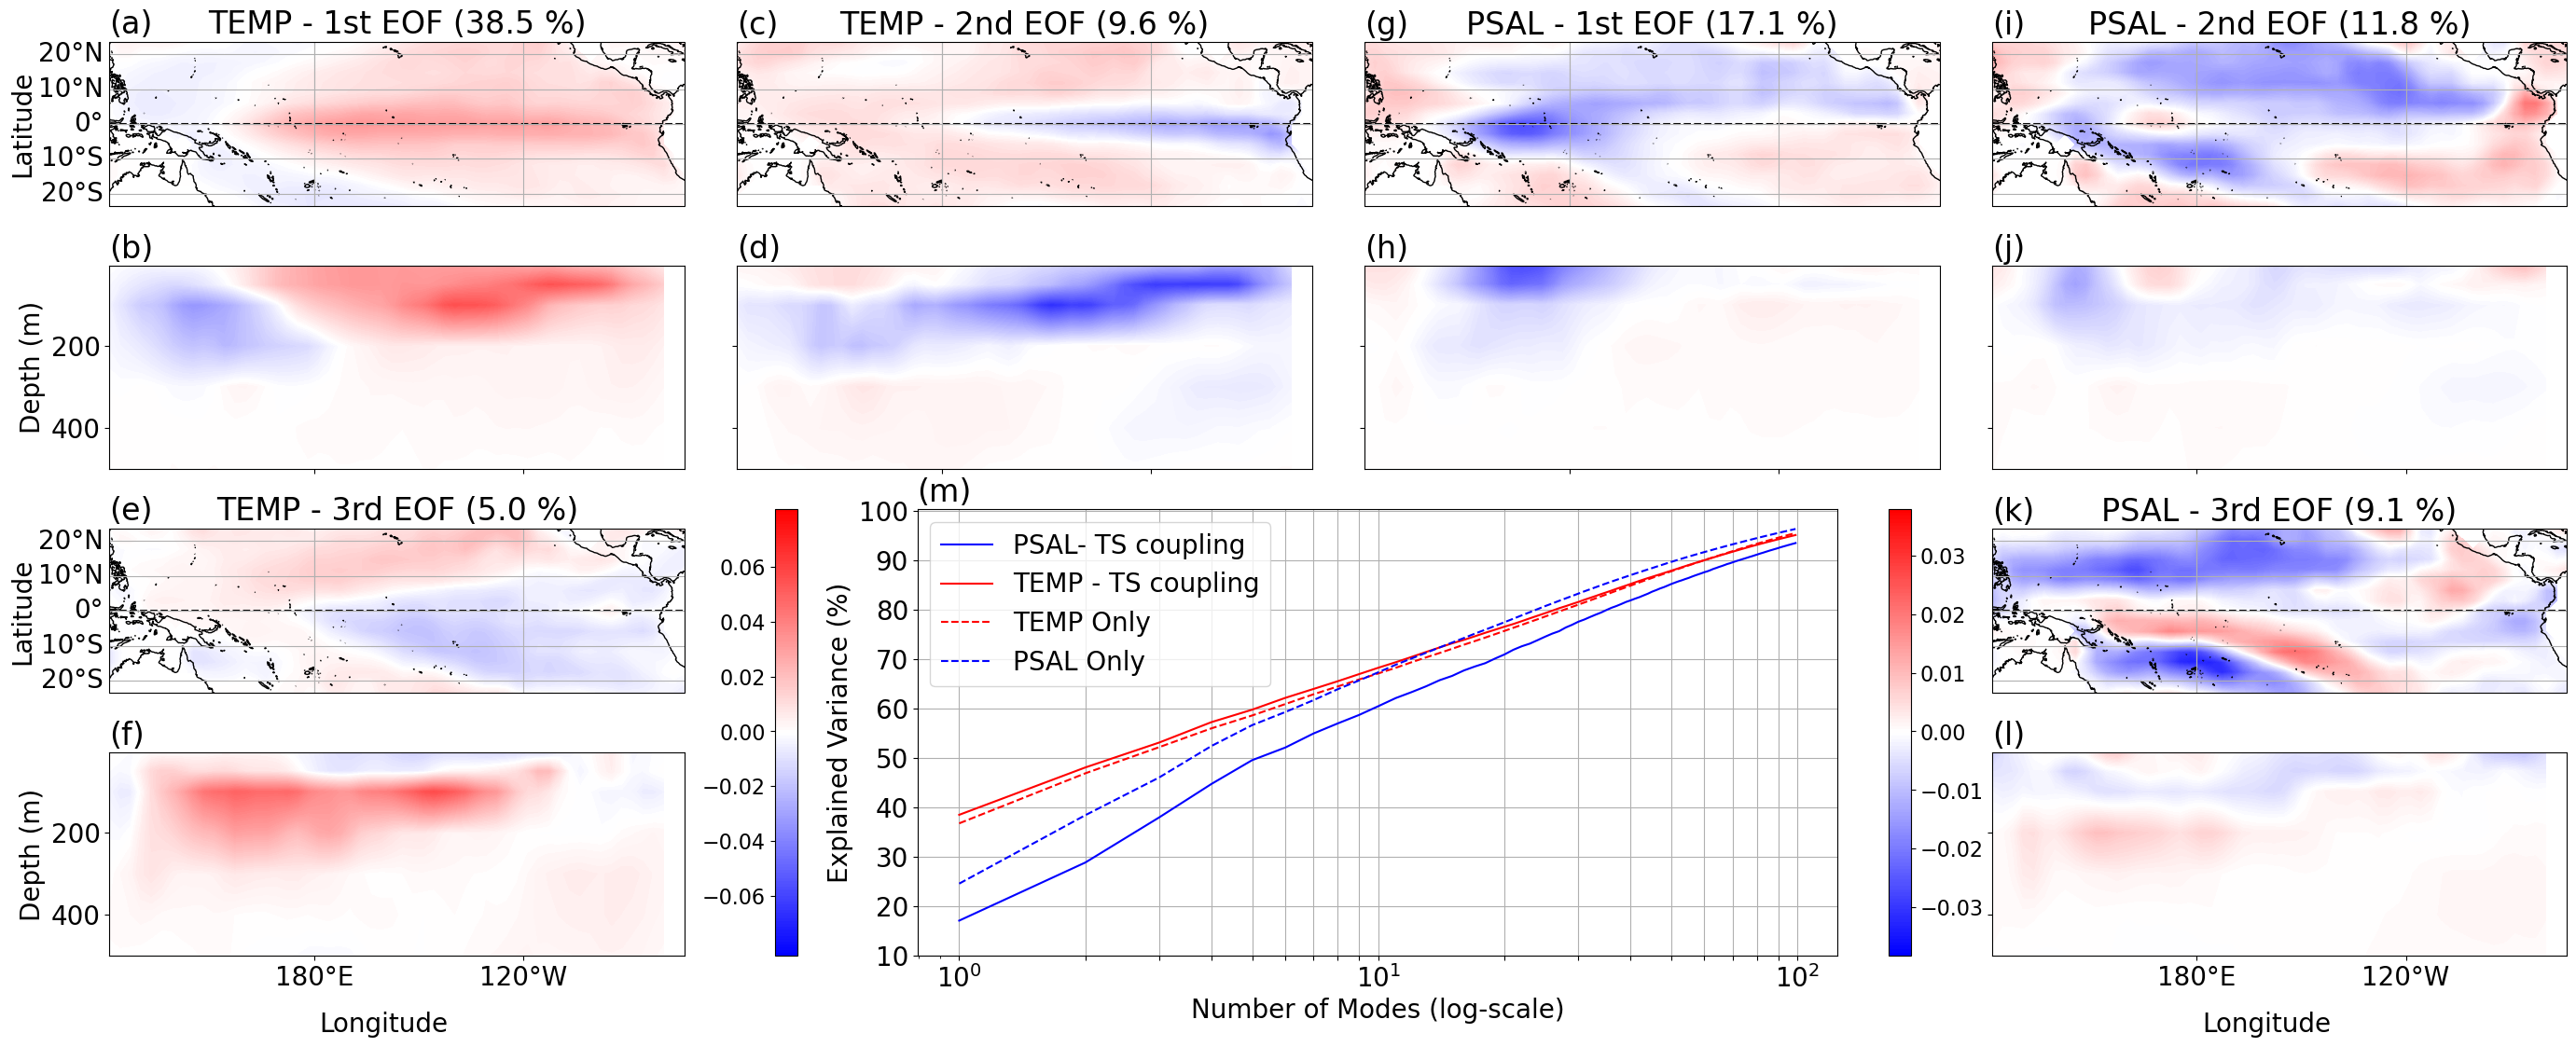

In [47]:

matplotlib.rcParams.update({'font.size': 20})
from cartopy.crs import PlateCarree 
from cartopy.feature import COASTLINE as COASTLINE
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(17*2,13))

gs0 = gridspec.GridSpec(4,8, figure=fig)

redAnDA4 = RealAnDA_TS7.copy().isel(var=0)
redAnDA4 = redAnDA4.assign({'functions':redAnDA4['functions']*-(AlphabetR['alpha'].mean('time').rename({"latitude":"Lat","longitude":"Lon"}).values[:,np.newaxis])})
mmod = 0
der = 0
alphabet = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)']
alpind = 0
ax01 = fig.add_subplot(gs0[0,:2],projection=PlateCarree(central_longitude=180))
ax04 = fig.add_subplot(gs0[1,:2],sharex=ax01)
ax01.set_title(alphabet[alpind],loc='left')
ax04.set_title(alphabet[alpind+1],loc='left')
alpind+=2



vmax = (np.round(np.abs(redAnDA4['functions']).max(skipna=True),3)*.5).values
lvls= (np.arange(-vmax,vmax,redAnDA4.functions.std().values/10))

clmsh=ax01.contourf(RCR['longitude'].values+180,RCR['latitude'].values,redAnDA4['functions'].isel(depth=0,modes=mmod),cmap=plt.cm.bwr,levels=lvls)
ax04.contourf(RCR['longitude'].values-180,-RCR['depth'].values,redAnDA4['functions'].isel(Lat=8,modes=mmod),cmap=plt.cm.bwr,levels=lvls)
ax01.add_feature(COASTLINE)
grdl=ax01.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.bottom_labels=False

ax04.set_xticks([0,60])
ax04.set_xticklabels(['',''])
ax01.axhline(RCR['latitude'][8],linestyle='--',c='k')


ax04.set_yticks([-400,-200])
ax04.set_yticklabels(['400','200'])


ax04.set_ylabel('Depth (m)')
# ax04.text(20, -1900, 'Longitude', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor')
ax01.text(-80, 0, 'Latitude', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor')

ax01.set_title('TEMP - 1st EOF ('+str(np.round(100*cumul_TS_t[1]-100*cumul_TS_t[0],1))+' %)')

der+=1

ax01 = fig.add_subplot(gs0[0,2:4],projection=PlateCarree(central_longitude=180))
ax04 = fig.add_subplot(gs0[1,2:4],sharex=ax01)
ax01.set_title(alphabet[alpind],loc='left')
ax04.set_title(alphabet[alpind+1],loc='left')
alpind+=2

clmsh=ax01.contourf(RCR['longitude'].values+180,RCR['latitude'].values,redAnDA4['functions'].isel(depth=0,modes=der),cmap=plt.cm.bwr,levels=lvls)
ax04.contourf(RCR['longitude'].values-180,-RCR['depth'].values,redAnDA4['functions'].isel(Lat=8,modes=der),cmap=plt.cm.bwr,levels=lvls)
ax01.add_feature(COASTLINE)
grdl=ax01.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.left_labels=False
grdl.bottom_labels=False
grdl.top_labels=False
ax04.set_yticklabels([''])

ax01.axhline(RCR['latitude'][8],linestyle='--',c='k')
ax04.set_xticks([0,60])
ax04.set_xticklabels(['',''])
ax01.set_title('TEMP - 2nd EOF ('+str(np.round(100*cumul_TS_t[2]-100*cumul_TS_t[1],1))+' %)')

# ax04.set_ylabel('Depth')
# ax04.text(20, -1900, 'Longitude', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor')
# ax01.text(-80, 0, 'Latitude', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor')


der+=1

ax01 = fig.add_subplot(gs0[2,:2],projection=PlateCarree(central_longitude=180))
ax04 = fig.add_subplot(gs0[3,:2],sharex=ax01)
ax01.set_title(alphabet[alpind],loc='left')
ax04.set_title(alphabet[alpind+1],loc='left')
alpind+=2

clmsh=ax01.contourf(RCR['longitude'].values+180,RCR['latitude'].values,redAnDA4['functions'].isel(depth=0,modes=der),cmap=plt.cm.bwr,levels=lvls)
ax04.contourf(RCR['longitude'].values-180,-RCR['depth'].values,redAnDA4['functions'].isel(Lat=8,modes=der),cmap=plt.cm.bwr,levels=lvls)
ax01.add_feature(COASTLINE)
grdl=ax01.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.bottom_labels=False
ax01.axhline(RCR['latitude'][8],linestyle='--',c='k')
ax04.set_xticks([0,60])
ax04.set_xticklabels(['180°E','120°W'])
ax01.set_title('TEMP - 3rd EOF ('+str(np.round(100*cumul_TS_t[3]-100*cumul_TS_t[2],1))+' %)')

ax04.set_yticks([-400,-200])
ax04.set_yticklabels(['400','200'])
ax04.set_ylabel('Depth (m)')
ax04.text(20, -700, 'Longitude', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor')
ax01.text(-80, 0, 'Latitude', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor')





redAnDA4 = RealAnDA_TS7.copy().isel(var=1)
redAnDA4 = redAnDA4.assign({'functions':redAnDA4['functions']*-(AlphabetR['beta'].mean('time').rename({"latitude":"Lat","longitude":"Lon"}).values[:,np.newaxis])})


vmax = (np.round(np.abs(redAnDA4['functions']).max(skipna=True),3)*.85).values
lvls= (np.arange(-vmax,vmax,redAnDA4.functions.std().values/10))

mmod = 0
der = 0
ax01 = fig.add_subplot(gs0[0,4:6],projection=PlateCarree(central_longitude=180))
ax04 = fig.add_subplot(gs0[1,4:6],sharex=ax01)
ax01.set_title(alphabet[alpind],loc='left')
ax04.set_title(alphabet[alpind+1],loc='left')

alpind+=2


# vmax = np.round(np.abs(redAnDA4['functions']).max(),3)*.7
# lvls= np.arange(-vmax,vmax,np.ceil(redAnDA4.functions.std()/10))

clmsh2=ax01.contourf(RCR['longitude'].values+180,RCR['latitude'].values,redAnDA4['functions'].isel(depth=0,modes=mmod),cmap=plt.cm.bwr,levels=lvls)
ax04.contourf(RCR['longitude'].values-180,-RCR['depth'].values,redAnDA4['functions'].isel(Lat=8,modes=mmod),cmap=plt.cm.bwr,levels=lvls)
ax01.add_feature(COASTLINE)
grdl=ax01.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.left_labels=False
grdl.bottom_labels=False
grdl.top_labels=False
ax04.set_xticks([0,60])
ax04.set_xticklabels(['',''])

ax04.set_yticklabels([''])
ax01.axhline(RCR['latitude'][8],linestyle='--',c='k')
ax01.set_title('PSAL - 1st EOF ('+str(np.round(100*cumul_TS_s[1]-100*cumul_TS_s[0],1))+' %)')

# ax04.set_ylabel('Depth')
# ax04.text(20, -1900, 'Longitude', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor')
# ax01.text(-80, 0, 'Latitude', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor')


der+=1

ax01 = fig.add_subplot(gs0[0,6:8],projection=PlateCarree(central_longitude=180))
ax04 = fig.add_subplot(gs0[1,6:8],sharex=ax01)
ax01.set_title(alphabet[alpind],loc='left')
ax04.set_title(alphabet[alpind+1],loc='left')
alpind+=2

clmsh2=ax01.contourf(RCR['longitude'].values+180,RCR['latitude'].values,redAnDA4['functions'].isel(depth=0,modes=der),cmap=plt.cm.bwr,levels=lvls)
ax04.contourf(RCR['longitude'].values-180,-RCR['depth'].values,redAnDA4['functions'].isel(Lat=8,modes=der),cmap=plt.cm.bwr,levels=lvls)
ax01.add_feature(COASTLINE)
grdl=ax01.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.left_labels=False
grdl.bottom_labels=False
grdl.top_labels=False
ax01.axhline(RCR['latitude'][8],linestyle='--',c='k')
ax01.set_title('PSAL - 2nd EOF ('+str(np.round(100*cumul_TS_s[2]-100*cumul_TS_s[1],1))+' %)')
ax04.set_xticks([0,60])
ax04.set_xticklabels(['',''])
ax04.set_yticklabels([''])
# ax04.set_ylabel('Depth')
# ax04.text(20, -1900, 'Longitude', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor')
# ax01.text(-80, 0, 'Latitude', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor')


der+=1

ax01 = fig.add_subplot(gs0[2,6:8],projection=PlateCarree(central_longitude=180))
ax04 = fig.add_subplot(gs0[3,6:8],sharex=ax01)
ax01.set_title(alphabet[alpind],loc='left')
ax04.set_title(alphabet[alpind+1],loc='left')
alpind+=2

clmsh2=ax01.contourf(RCR['longitude'].values+180,RCR['latitude'].values,redAnDA4['functions'].isel(depth=0,modes=der),cmap=plt.cm.bwr,levels=lvls)
ax04.contourf(RCR['longitude'].values-180,-RCR['depth'].values,redAnDA4['functions'].isel(Lat=8,modes=der),cmap=plt.cm.bwr,levels=lvls)
ax01.add_feature(COASTLINE)
grdl=ax01.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.left_labels=False
grdl.bottom_labels=False
grdl.top_labels=False

ax04.set_yticklabels([''])
ax04.set_xticks([0,60])
ax04.set_xticklabels(['180°E','120°W'])
ax01.axhline(RCR['latitude'][8],linestyle='--',c='k')
ax01.set_title('PSAL - 3rd EOF ('+str(np.round(100*cumul_TS_s[3]-100*cumul_TS_s[2],1))+' %)')

# ax04.set_ylabel('Depth')
ax04.text(20, -700, 'Longitude', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor')
# ax01.text(-80, 0, 'Latitude', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor')





ax = fig.add_subplot(gs0[2:5,2:6])
ax.set_title(alphabet[alpind],loc='left')

ax.plot(np.arange(1,100,1),cumul_TS_s[1:],c='b',label='PSAL- TS coupling')
ax.plot(np.arange(1,100,1),cumul_TS_t[1:],c='r',label='TEMP - TS coupling')
# ax.plot(np.arange(1,101,1),cumul_TS_tot,c='green',linewidth=2,label='PSAL & TEMP - \nTS coupling')
ax.plot(np.arange(1,100,1),cumul_t[1:],c='r',linestyle='--',label='TEMP Only')
ax.plot(np.arange(1,100,1),cumul_s[1:],c='b',linestyle='--',label='PSAL Only')
ax.set_xscale('log')
ax.set_xlabel('Number of Modes (log-scale)',fontsize=20)
ax.set_ylabel('Explained Variance (%)',fontsize=20)
ax.set_xticks(np.array([1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]))
ax.set_yticks(np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]))
ax.set_yticklabels(np.array([10,20,30,40,50,60,70,80,90,100]))
ax.grid()
ax.legend()
cbar=plt.colorbar(clmsh,ax=ax,ticks=[-.15,-.1,-.06,-0.04,-0.02,0,0.02,0.04,.06,.1,.15],fraction=.05,location='left',orientation='vertical')#,label="POTM anomaly (°C)")
cbar.ax.tick_params(labelsize=16)
cbar=plt.colorbar(clmsh2,ax=ax,ticks=[-.03,-.02,-.01,0,.01,.02,.03],fraction=.05,location='right',orientation='vertical')#label="PSAL Anomaly (PSU)",
cbar.ax.tick_params(labelsize=16)
 
 
plt.savefig('../Article_SAL/EOFs_POTM_AND_PSAL_ExplVar_OCCIPUT2.png',format='png',bbox_inches= 'tight')

In [37]:
vmax

array(0.082)

In [25]:
redAnDA4.functions.isel

<xarray.DataArray 'functions' (depth: 8, modes: 15, Lat: 17, Lon: 56)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * Lat      (Lat) float64 -23.53 -20.59 -17.65 -14.71 ... 17.65 20.59 23.53
  * Lon      (Lon) float64 121.2 124.2 127.2 130.2 ... 277.2 280.2 283.2 286.2
  * depth    (depth) float32 5.0 10.0 50.0 100.0 200.0 300.0 400.0 500.0
    Var      object 'POTM'
    Depth    (depth) float32 5.0 10.0 50.0 100.0 200.0 300.0 400.0 500.0
    lat      (Lat, Lon) int64 0 0 0 0 0 0 0 0 0 0 ... 16 16 16 16 16 16 16 16 16
    lon      (Lat, Lon) int64 0 1 2 3 4 5 6 7 8 9 ... 47 48 49 50 51 52 53 54 55
Dimensions without coordinates: modes

# CALCULATE BIASES BETWEEN ISAS20, UNIVARS, REDANDA TS, IAP, AND EN4

In [197]:
(RCR['PSAL'].sel(latitude=0,method='nearest').sel(longitude=slice(180,360-110)).mean('time')-(IAPR['Psal'].groupby('time2.month')+IAPR['SClimato']).sel(latitude=0,method='nearest').sel(longitude=slice(180,360-110)).mean('time')).mean().values

array(-0.18101641)

In [199]:
(RCR['PSAL'].sel(latitude=0,method='nearest').sel(longitude=slice(180,360-110)).mean('time')-(EN4R['Psal'].groupby('time2.month')+EN4R['SClimato']).sel(latitude=0,method='nearest').sel(longitude=slice(180,360-110)).mean('time')).mean().values

array(0.04539216)

In [200]:
((IAPR['Psal'].groupby('time2.month')+IAPR['SClimato']).sel(latitude=0,method='nearest').sel(longitude=slice(180,360-110)).mean('time')-(EN4R['Psal'].groupby('time2.month')+EN4R['SClimato']).sel(latitude=0,method='nearest').sel(longitude=slice(180,360-110)).mean('time')).mean().values

array(0.22640857)

In [209]:

np.mean(AbsPsal_TS6[:].sel(Lat=0,method='nearest').sel(Lon=slice(180,360-110)).rename({'Lon':'longitude'}).mean('time')-(IAPR['Psal'].groupby('time2.month')+IAPR['SClimato']).sel(latitude=0,method='nearest').sel(longitude=slice(180,360-110)).mean('time')).compute()


<xarray.DataArray ()>
array(-0.19189021)
Coordinates:
    Lat       float64 0.0
    Var       object 'PSAL'
    latitude  float64 0.0

In [210]:
np.mean(AbsPsal_TS6[:].sel(Lat=0,method='nearest').sel(Lon=slice(180,360-110)).rename({'Lon':'longitude'}).mean('time')-(EN4R['Psal'].groupby('time2.month')+EN4R['SClimato']).sel(latitude=0,method='nearest').sel(longitude=slice(180,360-110)).mean('time')).compute()

<xarray.DataArray ()>
array(0.03451836)
Coordinates:
    Lat       float64 0.0
    Var       object 'PSAL'
    latitude  float64 0.0

In [211]:
np.mean(AbsPsal_Univar[:].sel(Lat=0,method='nearest').sel(Lon=slice(180,360-110)).rename({'Lon':'longitude'}).mean('time')-(IAPR['Psal'].groupby('time2.month')+IAPR['SClimato']).sel(latitude=0,method='nearest').sel(longitude=slice(180,360-110)).mean('time')).compute()

<xarray.DataArray ()>
array(-0.19536754)
Coordinates:
    Lat       float64 0.0
    latitude  float64 0.0

In [195]:
np.mean(AbsPsal_Univar[:].mean('time')-(EN4R['Psal'].groupby('time2.month')+EN4R['SClimato']).mean('time')).compute()

<xarray.DataArray ()>
array(0.00545972)

# GENERATE FIGURE 9

/tmp/ipykernel_2005737/1383086329.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','','','','','','',''])
/tmp/ipykernel_2005737/1383086329.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','','','','','','',''])
/tmp/ipykernel_2005737/1383086329.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','','','','','','',''])


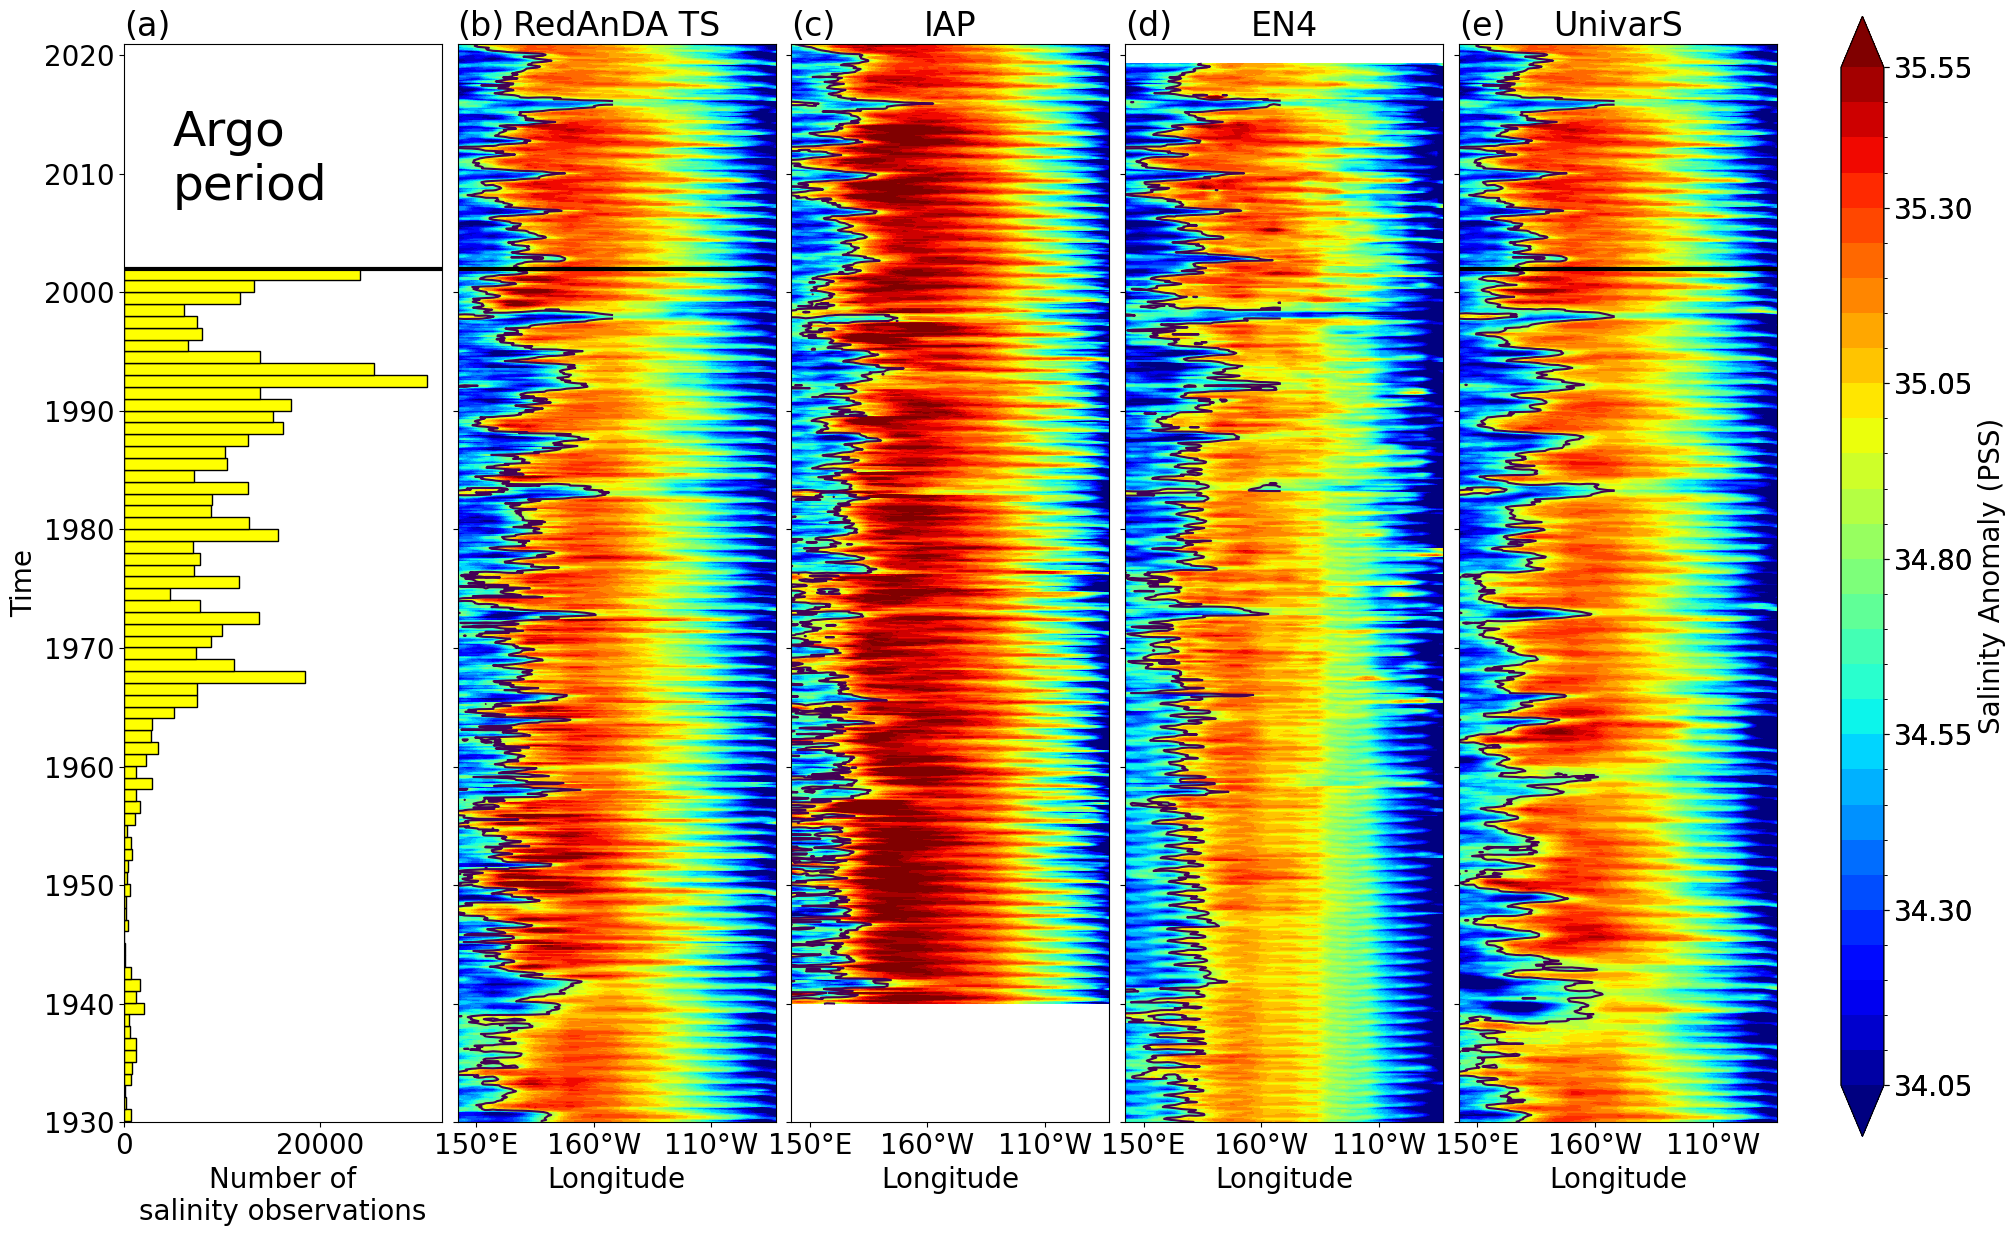

In [14]:
fig=plt.figure(figsize=(16*4/3,14))
matplotlib.rcParams.update({'font.size': 20})
ddepth=0
# Btime=Btime[:]

# (RCR['PSAL'].groupby('time2.month')-RC['S_Climato'])[:].isel(depth=ddepth).sel({"longitude":slice(130,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contourf(levels=np.arange(-1,1,.1),y='time2',add_colorbar=False)

# enechantillonT = EN[['POTM','JULD']].stack({'ALL':["N_PROF",'depth']}).dropna('ALL')
enechantillonST = EN[['PSAL','JULD']].stack({'ALL':["N_PROF",'depth']}).dropna('ALL')


ax=fig.add_subplot(1,5,1,)
ax.set_title('(a)',loc='left')# enechantillonT.JULD.dropna('ALL').plot.hist(bins=72,ax=ax,orientation=u'horizontal',label='Temperature',fc='b',ec='k')[-1]

enechantillonST.JULD.dropna('ALL').plot.hist(bins=72,ax=ax,orientation=u'horizontal',label='Salinity',fc='yellow',ec='k')[-1]
ax.set_ylim(np.datetime64('1930-01'),np.datetime64('2020-12'))
ax.set_yticks(np.arange(np.datetime64('1930'),np.datetime64('2030'),np.timedelta64(10,'Y')))
ax.set_yticklabels(np.arange(np.datetime64('1930'),np.datetime64('2030'),np.timedelta64(10,'Y')))
ax.axhline(np.datetime64('2002-01'),c='k',linewidth=3)

ax.set_xlabel('Number of\nsalinity observations')
ax.set_ylabel('Time')
ax.text(5000, np.datetime64('2007-10'),'Argo\nperiod',fontsize=35)
# ax.legend()


ax=fig.add_subplot(1,5,2,)
ax.set_title('(b)',loc='left')

ctrf=(AbsPsal_TS7).isel(depth=ddepth).sel({"Lon":slice(140,-80+360),'Lat':slice(-5,5)}).mean('Lat',skipna=True).plot.contourf(levels=34.8+np.arange(-.75,.75,.05),extend='both',y='JULD',add_colorbar=False,cmap=plt.cm.jet)
(AbsPsal_TS7).where(AbsPsal_TS7.Lon<=210).isel(depth=ddepth).sel({"Lon":slice(140,-80+360),'Lat':slice(-5,5)}).mean('Lat',skipna=True).plot.contour(levels=[34.8,39],y='JULD',add_colorbar=False)

ctrf=(RCR['PSAL']).isel(depth=ddepth).sel({"longitude":slice(140,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contourf(levels=34.8+np.arange(-.75,.75,.05),extend='both',y='time2',add_colorbar=False,cmap=plt.cm.jet)
(RCR['PSAL']).where(RCR.longitude<=210).isel(depth=ddepth).sel({"longitude":slice(140,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contour(levels=[34.8,39],y='time2',add_colorbar=False)
# plt.xlim(225,275)

ax.set_yticks(np.arange(np.datetime64('1930'),np.datetime64('2010'),np.timedelta64(10,'Y')))
ax.axhline(np.datetime64('2002-01'),c='k',linewidth=3)
ax.set_yticklabels(['','','','','','','',''])
ax.set_ylabel('')
# ax.set_ylim(np.datetime64('1930-01'),np.datetime64('2002-01'))
ax.set_ylim(np.datetime64('1930-01'),np.datetime64('2020-12'))
ax.set_title('RedAnDA TS')
ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])
ax.set_xlabel('Longitude')

ax=fig.add_subplot(1,5,3)
ax.set_title('(c)',loc='left')


(IAPR['Psal'].groupby('time2.month')+IAPR['SClimato']).isel(depth=ddepth).sel({"longitude":slice(140,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contourf(levels=34.8+np.arange(-.75,.75,.05),extend='both',y='time2',add_colorbar=False,cmap=plt.cm.jet)
(IAPR['Psal'].groupby('time2.month')+IAPR['SClimato']).where(IAPR.longitude<=210).isel(depth=ddepth).sel({"longitude":slice(140,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contour(levels=[34.8,39],y='time2',add_colorbar=False)
ax.set_title('IAP')
# ax.set_ylim(np.datetime64('1930-01'),np.datetime64('2002-01'))
ax.set_ylim(np.datetime64('1930-01'),np.datetime64('2020-12'))
ax.set_yticklabels(['','','','','','','',''])
ax.set_ylabel('')
ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])
ax.set_xlabel('Longitude')

ax=fig.add_subplot(1,5,4)
ax.set_title('(d)',loc='left')

(EN4R['Psal'].groupby('time2.month')+EN4R['SClimato'])[:].isel(depth=ddepth).sel({"longitude":slice(140,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contourf(levels=34.8+np.arange(-.75,.75,.05),extend='both',y='time2',add_colorbar=False,cmap=plt.cm.jet)
(EN4R['Psal'].groupby('time2.month')+EN4R['SClimato']).where(EN4R.longitude<=210).isel(depth=ddepth).sel({"longitude":slice(140,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contour(levels=[34.8,39],y='time2',add_colorbar=False)

ax.set_title("EN4")
# ax.set_ylim(np.datetime64('1930-01'),np.datetime64('2002-01'))
ax.set_ylim(np.datetime64('1930-01'),np.datetime64('2020-12'))
ax.set_yticklabels(['','','','','','','',''])
plt.colorbar(ctrf,cax=plt.axes([.93,.1,.02,.8]),ticks=[34.8-.75,34.8-.5,34.8-.25,34.8,34.8+.25,34.8+.50,34.8+.750])
plt.subplots_adjust(wspace=0.05)
ax.set_ylabel('')
ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])
ax.set_xlabel('Longitude')


ax=fig.add_subplot(1,5,5)
ax.set_title('(e)',loc='left')

ctrf=(AbsPsal_Univar).isel(depth=ddepth).sel({"Lon":slice(140,-80+360),'Lat':slice(-5,5)}).mean('Lat',skipna=True).plot.contourf(levels=34.8+np.arange(-.75,.75,.05),extend='both',y='JULD',add_colorbar=False,cmap=plt.cm.jet)
(AbsPsal_Univar).where(AbsPsal_Univar.Lon<=210).isel(depth=ddepth).sel({"Lon":slice(140,-80+360),'Lat':slice(-5,5)}).mean('Lat',skipna=True).plot.contour(levels=[34.8,39],y='JULD',add_colorbar=False)
ax.axhline(np.datetime64('2002-01'),c='k',linewidth=3)
ctrf=(RCR['PSAL']).isel(depth=ddepth).sel({"longitude":slice(140,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contourf(levels=34.8+np.arange(-.75,.75,.05),extend='both',y='time2',add_colorbar=False,cmap=plt.cm.jet)
(RCR['PSAL']).where(RCR.longitude<=210).isel(depth=ddepth).sel({"longitude":slice(140,-80+360),'latitude':slice(-5,5)}).mean('latitude',skipna=True).plot.contour(levels=[34.8,39],y='time2',add_colorbar=False)
ax.set_title("UnivarS")
# ax.set_ylim(np.datetime64('1930-01'),np.datetime64('2002-01'))
ax.set_ylim(np.datetime64('1930-01'),np.datetime64('2020-12'))
ax.set_yticklabels(['','','','','','','',''])
plt.colorbar(ctrf,cax=plt.axes([.93,.1,.02,.8]),ticks=[34.8-.75,34.8-.5,34.8-.25,34.8,34.8+.25,34.8+.50,34.8+.750],label='Salinity Anomaly (PSS)')
plt.subplots_adjust(wspace=0.05)
ax.set_ylabel('')
ax.set_xticks([150,200,250])
ax.set_xticklabels(['150°E','160°W','110°W'])
ax.set_xlabel('Longitude')

plt.savefig('Article_SAL/ABSSAL_Hovmoller_Real_TS7.png',bbox_inches='tight',)

# CALCULATE SALINITY-BASED ENSO INDICES ACCORDING TO  QU & YU 2014

In [21]:

soi = np.ravel(np.loadtxt('soi.txt')[np.where((np.loadtxt('soi.txt')[:,0]>=1930)&(np.loadtxt('soi.txt')[:,0]<=2001)),1:])

soi2 = np.ravel(np.loadtxt('soi.txt')[np.where((np.loadtxt('soi.txt')[:,0]>=2002)),1:])


soi = np.ravel(soi.reshape((-1,12))-soi2.reshape((-1,12)).mean(0))
soi2 = np.ravel(soi2.reshape((-1,12))-soi2.reshape((-1,12)).mean(0))


noaa = np.ravel(np.loadtxt('nino34_2.txt')[np.where((np.loadtxt('nino34_2.txt')[:,0]>=1930)&(np.loadtxt('nino34_2.txt')[:,0]<=2001)),1:])

noaa2 = np.ravel(np.loadtxt('nino34_2.txt')[np.where((np.loadtxt('nino34_2.txt')[:,0]>=2002)),1:])




x=(AbsPsal_TS6).where(AbsPsal_TS6.Lon<=210).isel(depth=0).sel({'Lat':slice(-5,5)}).mean('Lat',skipna=True).compute()
xts7=(AbsPsal_TS7).where(AbsPsal_TS7.Lon<=210).isel(depth=0).sel({'Lat':slice(-5,5)}).mean('Lat',skipna=True).compute()
x2=(IAPR['Psal'].groupby('time2.month')+IAPR['SClimato']).where(IAPR.longitude<=210).isel(depth=0).sel({'latitude':slice(-5,5)}).mean('latitude',skipna=True).compute()
x3=(EN4R['Psal'].groupby('time2.month')+EN4R['SClimato']).where(EN4R.longitude<=210).isel(depth=0).sel({'latitude':slice(-5,5)}).mean('latitude',skipna=True).compute()
x4=(AbsPsal_Univar).where(AbsPsal_Univar.Lon<=210).isel(depth=0).sel({'Lat':slice(-5,5)}).mean('Lat',skipna=True).compute()
# x42=(AbsPsal_Univar2).where(AbsPsal_Univar2.Lon<=210).isel(depth=0).sel({'Lat':slice(-5,5)}).mean('Lat',skipna=True).compute()
x5=(RCR['PSAL']).where(RCR['PSAL'].longitude<=210).isel(depth=0).sel({'latitude':slice(-5,5)}).mean('latitude',skipna=True).compute()


appx=[]
appxts7=[]
appx2=[]
appx3=[]
appx4=[]
# appx42=[]
appx5=[]
for tim in range(0,x['time'].size):
    appx.append(x.Lon.values[np.max(np.where(x.values[tim]<=34.8)[0])])
    
for tim in range(0,xts7['time'].size):
    appxts7.append(xts7.Lon.values[np.max(np.where(xts7.values[tim]<=34.8)[0])])
    
for tim in range(0,x2['time'].size):
    appx2.append(x2.longitude.values[np.max(np.where(x2.values[tim]<=34.8)[0])])
    
for tim in range(0,x3['time'].size):
    appx3.append(x3.longitude.values[np.max(np.where(x3.values[tim]<=34.8)[0])])
    
for tim in range(0,x4['time'].size):
    appx4.append(x4.Lon.values[np.max(np.where(x4.values[tim]<=34.8)[0])])
    
# for tim in range(0,x42['time'].size):
#     appx42.append(x42.Lon.values[np.max(np.where(x42.values[tim]<=34.8)[0])])
    
for tim in range(0,x5['time'].size):
    appx5.append(x5.longitude.values[np.max(np.where(x5.values[tim]<=34.8)[0])])
    
appx=np.array(appx)
appxts7=np.array(appxts7)
appx2=np.array(appx2)
appx3=np.array(appx3)
appx4=np.array(appx4)
# appx42=np.array(appx42)
appx5=np.array(appx5)

In [22]:
np.mean(appx)

165.11458333333334

In [23]:
np.mean(appxts7)

165.13194444444446

In [24]:
np.mean(appx2)

159.2530487804878

In [25]:
np.mean(appx3)

167.3582402234637

In [26]:
np.mean(appx4)

166.48958333333334

# CALCULATE RUNNING CORRELATIONS BASED ON QU & YU 2014 INDICES WITH NINO3.4

In [147]:
totcorTS3=np.array([np.corrcoef(np.concatenate((appxts7,appx5))[1:][i:i+8*12],np.concatenate((noaa,noaa2[:227]))[i:i+8*12])[0,1] for i in range(0,1092-8*12)])

In [148]:
totcorUni=np.array([np.corrcoef(np.concatenate((appx4,appx5))[1:][i:i+8*12],np.concatenate((noaa,noaa2[:227]))[i:i+8*12])[0,1] for i in range(0,1092-8*12)])

In [149]:
totcorEN4=np.array([np.corrcoef(appx3[3*120:][1:][i:i+8*12],np.concatenate((noaa,noaa2[:207]))[i:i+8*12])[0,1] for i in range(0,1092-8*12)])

In [150]:
totcorIAP=np.array([np.corrcoef(appx2[:][1:][i:i+8*12],np.concatenate((noaa[120:],noaa2[:239]))[i:i+8*12])[0,1] for i in range(0,1092-120-8*12)])

In [151]:
print(np.mean(totcorIAP),np.std(totcorIAP))

0.4834391258247103 0.21915586498145767


In [152]:
print(np.mean(totcorEN4),np.std(totcorEN4))

0.463927216672604 0.2828549998708662


In [153]:
print(np.mean(totcorUni),np.std(totcorUni))

0.6439214560971012 0.28086958677679386


In [154]:
print(np.mean(totcorTS3),np.std(totcorTS3))

0.7368267950066478 0.1728633738069394


In [155]:
print(np.mean(totcorEN4[120:]),np.std(totcorEN4[120:]))

0.5052184920730382 0.27461928400967267


In [156]:
print(np.mean(totcorUni[120:]),np.std(totcorUni[120:]))

0.7111066361004773 0.22111008300927765


In [157]:
print(np.mean(totcorTS3[120:]),np.std(totcorTS3[120:]))

0.7736366511823217 0.138746457466547


# CALCULATE NINO INDICES FROM SINGH ET AL 2011

 (A) is delimited between 2°S–2°N and 150°E–170°E, the second (B) between 2°S–2°N and 170°E–170°W and the third (C) between 160°E–160°W and 25°S–10°S 
singhENSO = (C-(A+B)) 

In [65]:
singh_TS3 = (Psal_TS6).isel(depth=0).sel(Lat=slice(-25,-10),Lon=slice(160,360-160)).mean(('Lat','Lon'))-(Psal_TS6).isel(depth=0).sel(Lat=slice(-2,2),Lon=slice(150,170)).mean(('Lat','Lon'))-(Psal_TS6).isel(depth=0).sel(Lat=slice(-2,2),Lon=slice(170,190)).mean(('Lat','Lon'))
singh_TS3=((singh_TS3)/np.sqrt(np.mean((singh_TS3)**2))).values
# singh_TS7 = (AbsPsal_TS7).isel(depth=0).sel(Lat=slice(-25,-10),Lon=slice(160,360-160)).mean(('Lat','Lon'))-(AbsPsal_TS7).isel(depth=0).sel(Lat=slice(-2,2),Lon=slice(150,170)).mean(('Lat','Lon'))-(AbsPsal_TS7).isel(depth=0).sel(Lat=slice(-2,2),Lon=slice(170,190)).mean(('Lat','Lon'))
# singh_TS7=((singh_TS7-np.mean(singh_TS7))/np.sqrt(np.mean((singh_TS7-np.mean(singh_TS7))**2))).values
singh_IAP = (IAPR['Psal']).isel(depth=0).sel(latitude=slice(-25,-10),longitude=slice(160,360-160)).mean(('latitude','longitude'))-(IAPR['Psal']).isel(depth=0).sel(latitude=slice(-2,2),longitude=slice(150,170)).mean(('latitude','longitude'))-(IAPR['Psal']).isel(depth=0).sel(latitude=slice(-2,2),longitude=slice(170,190)).mean(('latitude','longitude'))
singh_IAP=((singh_IAP)/np.sqrt(np.mean((singh_IAP)**2))).values
singh_EN4 = (EN4R['Psal']).isel(depth=0).sel(latitude=slice(-25,-10),longitude=slice(160,360-160)).mean(('latitude','longitude'))-(EN4R['Psal']).isel(depth=0).sel(latitude=slice(-2,2),longitude=slice(150,170)).mean(('latitude','longitude'))-(EN4R['Psal']).isel(depth=0).sel(latitude=slice(-2,2),longitude=slice(170,190)).mean(('latitude','longitude'))
singh_EN4=((singh_EN4)/np.sqrt(np.mean((singh_EN4)**2))).values
singh_Univar = (Psal_Univar).isel(depth=0).sel(Lat=slice(-25,-10),Lon=slice(160,360-160)).mean(('Lat','Lon'))-(Psal_Univar).isel(depth=0).sel(Lat=slice(-2,2),Lon=slice(150,170)).mean(('Lat','Lon'))-(Psal_Univar).isel(depth=0).sel(Lat=slice(-2,2),Lon=slice(170,190)).mean(('Lat','Lon'))
singh_Univar=((singh_Univar)/np.sqrt(np.mean((singh_Univar)**2))).values
# singh_Univar2 = (AbsPsal_Univar2).isel(depth=0).sel(Lat=slice(-25,-10),Lon=slice(160,360-160)).mean(('Lat','Lon'))-(AbsPsal_Univar2).isel(depth=0).sel(Lat=slice(-2,2),Lon=slice(150,170)).mean(('Lat','Lon'))-(AbsPsal_Univar2).isel(depth=0).sel(Lat=slice(-2,2),Lon=slice(170,190)).mean(('Lat','Lon'))
# singh_Univar2=((singh_Univar2-np.mean(singh_Univar2))/np.sqrt(np.mean((singh_Univar2-np.mean(singh_Univar2))**2))).values


singh_ISAS = (RCR['PSAL_detrend']).isel(depth=0).sel(latitude=slice(-25,-10),longitude=slice(160,360-160)).mean(('latitude','longitude'))-(RCR['PSAL_detrend']).isel(depth=0).sel(latitude=slice(-2,2),longitude=slice(150,170)).mean(('latitude','longitude'))-(RCR['PSAL_detrend']).isel(depth=0).sel(latitude=slice(-2,2),longitude=slice(170,190)).mean(('latitude','longitude'))
singh_ISAS=((singh_ISAS)/np.sqrt(np.mean((singh_ISAS)**2))).values



# CALCULATE RUNNING CORRELATIONS BASED ON SINGH ET AL 2011 INDICES WITH SOI

In [159]:
totcorTS3=np.array([np.corrcoef(np.concatenate((singh_TS7,singh_ISAS))[2:][i:i+31*12],np.concatenate((soi,soi2[:226]))[i:i+31*12])[0,1] for i in range(0,1092-31*12)])

In [160]:
totcorUni=np.array([np.corrcoef(np.concatenate((singh_Univar,singh_ISAS))[2:][i:i+31*12],np.concatenate((soi,soi2[:226]))[i:i+31*12])[0,1] for i in range(0,1092-31*12)])

In [161]:
totcorEN4=np.array([np.corrcoef(singh_EN4[3*120:][2:][i:i+31*12],np.concatenate((soi,soi2[:206]))[i:i+31*12])[0,1] for i in range(0,1092-31*12)])

In [162]:
totcorIAP=np.array([np.corrcoef(singh_IAP[2:][i:i+31*12],np.concatenate((soi[120:],soi2[:238]))[i:i+31*12])[0,1] for i in range(0,1092-120-31*12)])

In [164]:
print(np.mean(totcorEN4[120:]),np.std(totcorEN4[120:]))

-0.539802084082718 0.09518475184737296


In [165]:
print(np.mean(totcorUni[120:]),np.std(totcorUni[120:]))

-0.606247249657611 0.09760964185411246


In [166]:
print(np.mean(totcorTS3[120:]),np.std(totcorTS3[120:]))

-0.5861307646498453 0.0716932191740451


In [171]:
print(np.mean(totcorIAP),np.std(totcorIAP))

-0.5267041894948382 0.060794222448894014


In [172]:
print(np.mean(totcorEN4),np.std(totcorEN4))

-0.5083746490160098 0.11229473039715115


In [173]:
print(np.mean(totcorUni),np.std(totcorUni))

-0.5528943208475516 0.14976185853573198


In [174]:
print(np.mean(totcorTS3),np.std(totcorTS3))

-0.5619034054848233 0.08608660256279703


In [31]:
np.mean(singh_TS3).values

array(-34.55296421)

In [32]:
np.mean(singh_IAP).values

array(-34.82618196)

In [33]:
np.mean(singh_EN4).values

array(-34.4918697)

/tmp/ipykernel_2005737/3571591773.py:13: RuntimeWarning: Mean of empty slice
  return np.sqrt(np.nanmean((x.reshape((x.shape[0]//12,12,-1))-np.nanmean(x.reshape((x.shape[0]//12,12,-1)),0)[np.newaxis]).reshape((-1,x.shape[1],x.shape[2]))**2,index))
/tmp/ipykernel_2005737/3571591773.py:20: RuntimeWarning: Mean of empty slice
  ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSSU_TS7[120*1:8*120],0),vmin=0,vmax=2e-5,extend='max',levels=np.arange(0,2e-5,.5e-5),colors='k',linestyles=[':','-.','--','-'])
/tmp/ipykernel_2005737/3571591773.py:37: RuntimeWarning: Mean of empty slice
  ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSS_TS7[120*1:8*120],0),vmin=0,vmax=4e-5,extend='max',levels=np.arange(0,4e-5,1e-5),colors='k',linestyles=[':','-.','--','-'])
/tmp/ipykernel_2005737/3571591773.py:56: RuntimeWarning: Mean of empty slice
  ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSSU_Univar[120*1:8*120],0),vmin=0,vmax=2e-5,extend='max',levels=np.arange(0

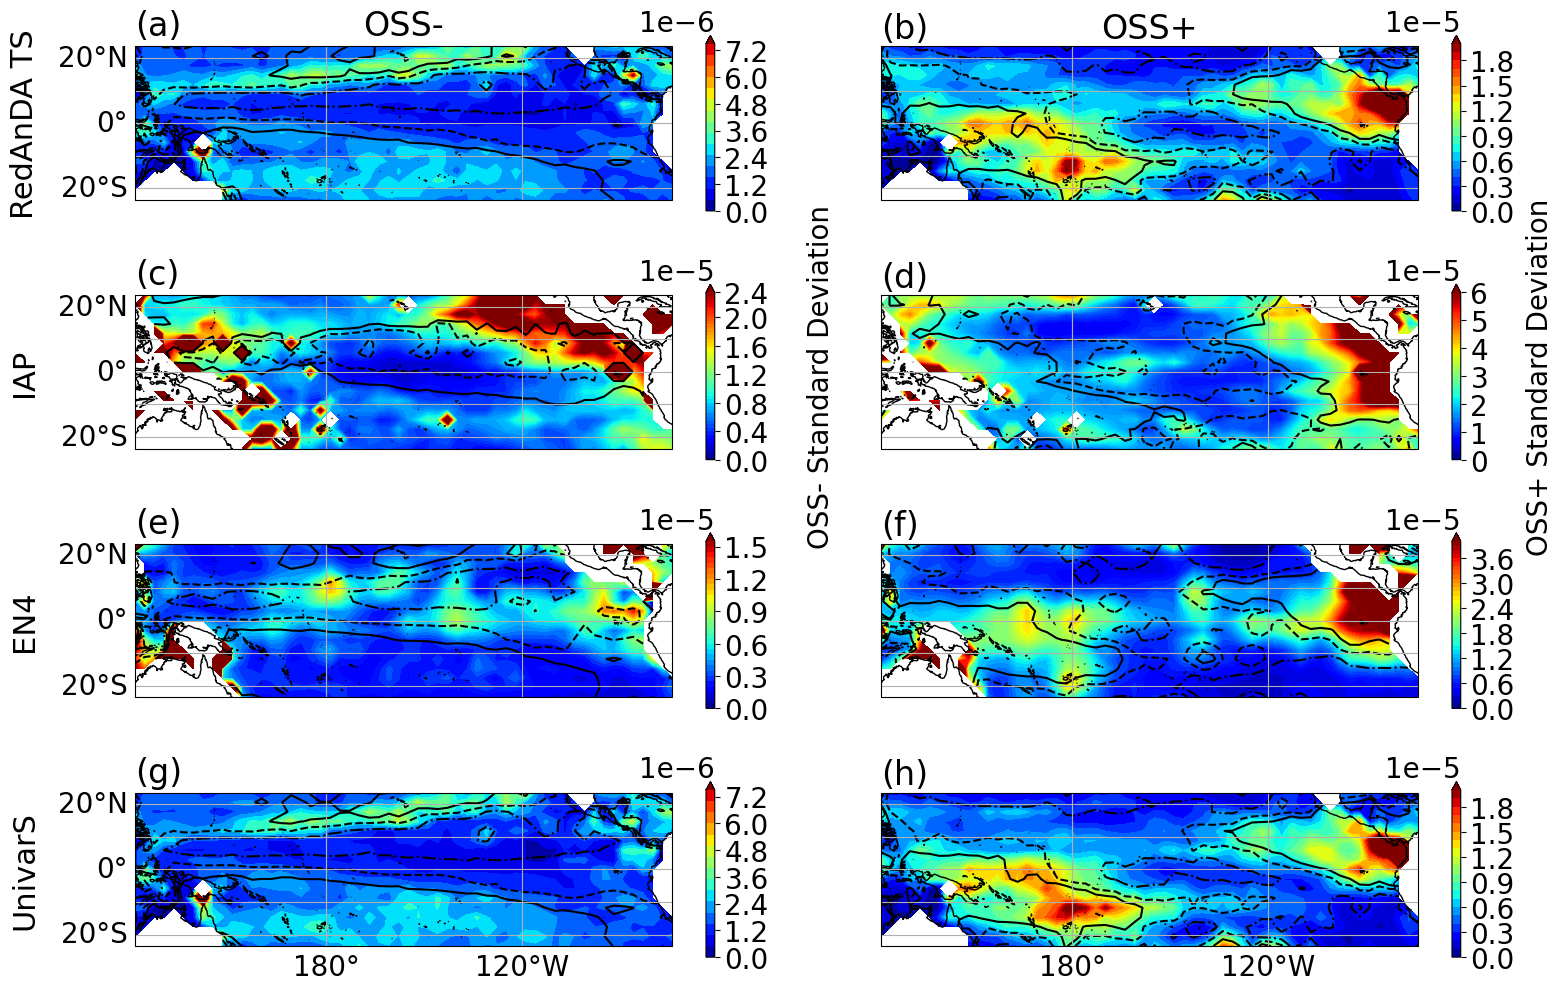

In [76]:
fig=plt.figure(figsize=(16,10.25))



alphabet = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)']
alpind=0





def rmsvar(x,index=0):
    return np.sqrt(np.nanmean((x.reshape((x.shape[0]//12,12,-1))-np.nanmean(x.reshape((x.shape[0]//12,12,-1)),0)[np.newaxis]).reshape((-1,x.shape[1],x.shape[2]))**2,index))

ax=fig.add_subplot(4,2,1,projection=PlateCarree(central_longitude=180))

ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1
ctr=ax.contourf( RCR['longitude']+180, RCR['latitude'],rmsvar(OSSU_TS7[120*1:8*120],0),vmin=0,vmax=8e-6,extend='max',levels=np.arange(0,8e-6,.5e-6),cmap=plt.cm.jet)
ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSSU_TS7[120*1:8*120],0),vmin=0,vmax=2e-5,extend='max',levels=np.arange(0,2e-5,.5e-5),colors='k',linestyles=[':','-.','--','-'])
plt.colorbar(ctr,ticks=[0,1.2e-6,2.4e-6,3.6e-6,4.8e-6,6e-6,7.2e-6])
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.bottom_labels=False
ax.set_title('OSS-')
ax.text(-97,0, 'RedAnDA TS',fontsize=22,rotation='vertical',va='center')
ax=fig.add_subplot(4,2,2,projection=PlateCarree(central_longitude=180))

ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1+1+1+1+1
ax.set_title('OSS+')
ctr=ax.contourf( RCR['longitude']+180, RCR['latitude'],rmsvar(OSS_TS7[1*120:8*120],0),vmin=0,vmax=2e-5,extend='max',levels=np.arange(0,2e-5,1e-6),cmap=plt.cm.jet)
ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSS_TS7[120*1:8*120],0),vmin=0,vmax=4e-5,extend='max',levels=np.arange(0,4e-5,1e-5),colors='k',linestyles=[':','-.','--','-'])
plt.colorbar(ctr)

# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.left_labels=False
grdl.bottom_labels=False



ax=fig.add_subplot(4,2,7,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1
ctr=ax.contourf( RCR['longitude']+180, RCR['latitude'],rmsvar(OSSU_Univar[120*1:8*120],0),vmin=0,vmax=8e-6,extend='max',levels=np.arange(0,8e-6,.5e-6),cmap=plt.cm.jet)
ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSSU_Univar[120*1:8*120],0),vmin=0,vmax=2e-5,extend='max',levels=np.arange(0,2e-5,.5e-5),colors='k',linestyles=[':','-.','--','-'])
plt.colorbar(ctr,ticks=[0,1.2e-6,2.4e-6,3.6e-6,4.8e-6,6e-6,7.2e-6])
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
ax.text(-97,0, 'UnivarS',fontsize=22,rotation='vertical',va='center')
# ax.set_title('Univar RedAnDA')
ax=fig.add_subplot(4,2,8,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind=4
ctr=ax.contourf( RCR['longitude']+180, RCR['latitude'],rmsvar(OSS_Univar[1*120:8*120],0),vmin=0,vmax=2e-5,extend='max',levels=np.arange(0,2e-5,1e-6),cmap=plt.cm.jet)
ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSS_Univar[120*1:8*120],0),vmin=0,vmax=4e-5,extend='max',levels=np.arange(0,4e-5,1e-5),colors='k',linestyles=[':','-.','--','-'])
plt.colorbar(ctr)

# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.left_labels=False





ax=fig.add_subplot(4,2,5,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1

# ax.set_title('EN4')
ax.text(-97,0, 'EN4',fontsize=22,rotation='vertical',va='center')

multi=2
ctr=ax.contourf( RCR['longitude']+180, RCR['latitude'],rmsvar(OSSU_EN4[4*120:11*120],0),vmin=0,vmax=multi*8e-6,extend='max',levels=np.arange(0,multi*8e-6,.5e-6),cmap=plt.cm.jet)
ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSSU_EN4[4*120:11*120],0),vmin=0,vmax=2e-5,extend='max',levels=np.arange(0,2e-5,.5e-5),colors='k',linestyles=[':','-.','--','-'])
plt.colorbar(ctr, ticks=[0,0.3e-5,0.6e-5,0.9e-5,1.2e-5,1.5e-5])
# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.bottom_labels=False
ax=fig.add_subplot(4,2,6,projection=PlateCarree(central_longitude=180))
ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind=2
ctr=ax.contourf( RCR['longitude']+180, RCR['latitude'],rmsvar(OSS_EN4[4*120:11*120],0),vmin=0,vmax=multi*2e-5,extend='max',levels=np.arange(0,multi*2e-5,1e-6),cmap=plt.cm.jet)
ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSS_EN4[4*120:11*120],0),vmin=0,vmax=4e-5,extend='max',levels=np.arange(0,4e-5,1e-5),colors='k',linestyles=[':','-.','--','-'])
plt.colorbar(ctr,ticks=[0,0.6e-5,1.2e-5,1.8e-5,2.4e-5,3e-5,3.6e-5])

# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.left_labels=False
grdl.bottom_labels=False

multi=3
ax=fig.add_subplot(4,2,3,projection=PlateCarree(central_longitude=180))

ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1
# ax.set_title('IAP')
ax.text(-97,0, 'IAP',fontsize=22,rotation='vertical',va='center')
ctrt=ax.contourf( RCR['longitude']+180, RCR['latitude'],rmsvar(OSSU_IAP[0*120:7*120],0),vmin=0,vmax=multi*8e-6,extend='max',levels=np.arange(0,multi*8e-6,.5e-6),cmap=plt.cm.jet)
ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSSU_IAP[0*120:7*120],0),vmin=0,vmax=2e-5,extend='max',levels=np.arange(0,2e-5,.5e-5),colors='k',linestyles=[':','-.','--','-'])
# plt.colorbar(ctrt)
plt.colorbar(ctrt,ticks=[0,.4e-5,.8e-5,1.2e-5,1.6e-5,2e-5,2.4e-5],label='\nOSS- Standard Deviation')

# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.bottom_labels=False
grdl.bottom_labels=False

ax=fig.add_subplot(4,2,4,projection=PlateCarree(central_longitude=180))

ax.set_title(alphabet[alpind],fontsize=24,loc='left')
alpind+=1
ctrt=ax.contourf( RCR['longitude']+180, RCR['latitude'],rmsvar(OSS_IAP[0*120:7*120],0),vmin=0,vmax=multi*2e-5,extend='max',levels=np.arange(0,multi*2e-5,1e-6),cmap=plt.cm.jet)
ax.contour( RCR['longitude']+180, RCR['latitude'],np.nanmean(OSS_IAP[0*120:7*120],0),vmin=0,vmax=4e-5,extend='max',levels=np.arange(0,4e-5,1e-5),colors='k',linestyles=[':','-.','--','-'])
plt.colorbar(ctrt,ticks=[0,1e-5,2e-5,3e-5,4e-5,5e-5,6e-5],label='\nOSS+ Standard Deviation')
# ax.set_ylim(-15,15)
ax.add_feature(COASTLINE)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
grdl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
grdl.right_labels=False
grdl.top_labels=False
grdl.left_labels=False
grdl.bottom_labels=False

plt.tight_layout()
plt.savefig('Article_SAL/Std_OSS&OSSU_TS7.png',dpi=300,bbox_inches='tight')